### <div align="center">Convolutional Neural Network (CNN)</div>

#### 10.1: Convolutional Neural Network (CNN)
- Disadvantages of using FCN (Fully Connected Neural Net) for image classification
  1. Too much computation
  2. Loss of spatial information
  3. Risk of overfitting
- Filters(Kernels) are nothing but the feature detectors.
- Benefits of pooling
  1. Reduces dimensions, computation
  2. Reduces overfitting
  3. Model is tolerant towards variantions, distortions etc.
- CNN by itself doesn't take care of rotation and scale, we need to have rotated, scaled samples in training dataset. If we do not have such samples then use Data Augmentation to generate rotated, scaled images.
- Convolutional Neural Networks (CNNs) excel at processing grid-like data such as images, identifying patterns through convolutions.
- They use kernels (filters) to extract spatial features like edges and textures from input data.
- Pooling layers reduce spatial dimensions, retaining essential information while minimizing computation and overfitting.
- CNN architectures combine convolution, pooling, and fully connected layers to learn hierarchical feature representations for tasks like image classification and object detection.
- CNNs by design cannot handle scale and rotation. To address this Include images in the training dataset with variety in scale and rotation use data augmentation to generate new images from the original dataset.
- Overview
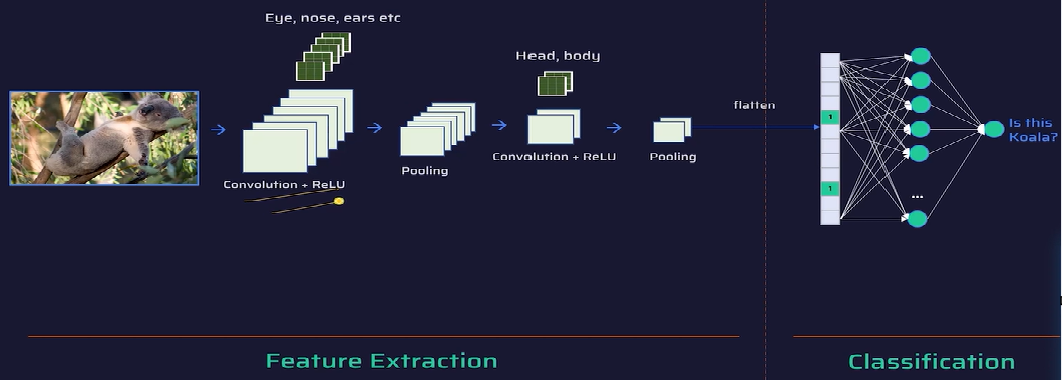

#### 10.2: Padding and Strides
- Padding preserves input dimensions during convolution, ensuring no loss of edge information.
- Strides control the movement of the convolutional filter, affecting output size and computation speed.
- Padding techniques like "same" and "valid" balance between maintaining dimensions and reducing output size.
- Adjusting padding and strides can influence feature extraction granularity and network efficiency.

#### 10.3: CIFAR10 Image Classification using CNN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
### Data Load
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../.././data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='../.././data', train=False, download=True, transform=transform)

In [8]:
len(train_dataset), len(test_dataset)

(50000, 10000)

In [9]:
batch_size = 100

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

##### Visualize a Few Images

In [10]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images[:8]))

In [ ]:
labels[:8]

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
[classes[i] for i in labels[:8]]

#### Train a Neural Network

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3,3), padding='same'),  # Output: (32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),        # Output: (32, 16, 16)
            
            nn.Conv2d(32, 64, kernel_size=(3,3)),             # Output: (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))         # Output: (64, 7, 7)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                # Flatten to (64 * 7 * 7 = 3136)
            nn.Linear(64 * 7 * 7, 600),                  # Corrected input size
            nn.ReLU(),
            nn.Linear(600, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
        )
        
    def forward(self, x):
        x = self.network(x)
        x = self.fc_layers(x)
        return x

In [ ]:
model = CNN()
dummy_input = torch.randn(1, 3, 32, 32)  # Single example with CIFAR-10 dimensions
output = model(dummy_input)
print("Output shape:", output.shape)  # Should be [1, 10]

In [ ]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

# Testing the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%")

#### 10.4: Data Augmentation
- Data augmentation increases the diversity of the training dataset by applying transformations like rotation, flipping, and scaling.
- Enhances model generalization by exposing it to varied scenarios, reducing overfitting.
- Common techniques include geometric transformations, color adjustments, cropping, and adding noise.
- Augmentation is performed dynamically during training, ensuring the model sees a new variation in each epoch.
- Particularly effective in computer vision tasks where gathering more data can be costly or impractical.

##### With Data Augmentation

In [ ]:
# import torchvision.transforms as transforms

transform_with_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_with_aug)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)

model_aug = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=learning_rate)

train_losses, val_losses, val_accuracy = train_model(model_aug, criterion, optimizer, train_loader_aug, test_loader, epochs=5)

#### 10.5: Transfer Learning
- Transfer learning is a machine learning technique where a pre-trained model on one task is reused or fine-tuned for a different but related task, such as using a model trained on cars to classify trucks.
- Transfer learning leverages pre-trained models to solve new, related tasks with limited data.
- It significantly reduces training time by reusing learned features from large datasets.
- Commonly used in tasks like image classification and natural language processing to achieve high accuracy with minimal effort.
- Transfer learning involves fine-tuning a pre-trained model or using it as a fixed feature extractor.
- Ideal for scenarios with limited data, enabling effective learning without starting from scratch.

#### MCQ
- How do padding and strides influence CNN operations?
  - They control output size and computation speed
- Why are pooling layers used in CNNs?
  - To reduce spatial dimensions while retaining essential information
- What is the role of kernels (filters) in CNNs?
  - To extract spatial features like edges and textures
- What challenges do CNNs face with scale and rotation in images?
  - They cannot handle scale and rotation without diverse training data or data augmentation
- How does transfer learning save time in training?
  - By reusing learned features from pre-trained models